In [1]:
import torch
import torchvision
import os
from os.path import join as j_
from PIL import Image
import pandas as pd
import numpy as np

# loading all packages here to start
from uni import get_encoder
from uni.downstream.extract_patch_features import extract_patch_features_from_dataloader
from uni.downstream.eval_patch_features.linear_probe import eval_linear_probe
from uni.downstream.eval_patch_features.fewshot import eval_knn, eval_fewshot
from uni.downstream.eval_patch_features.protonet import ProtoNet, prototype_topk_vote
from uni.downstream.eval_patch_features.metrics import get_eval_metrics, print_metrics
from uni.downstream.utils import concat_images
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Downloading UNI weights + Creating Model

Method 1: Following authentication (using ```huggingface_hub```), the ViT-L/16 model architecture with pretrained weights and image transforms for UNI can be directly loaded using the [timm](https://huggingface.co/docs/hub/en/timm) library. This method automatically downloads the model weights to the [huggingface_hub cache](https://huggingface.co/docs/huggingface_hub/en/guides/manage-cache) in your home directory (```~/.cache/huggingface/hub/models--MahmoodLab--UNI```), which ```timm``` will automatically find when using the commands below:

In [2]:
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
from huggingface_hub import login

login()  # login with your User Access Token, found at https://huggingface.co/settings/tokens

# pretrained=True needed to load UNI weights (and download weights for the first time)
# init_values need to be passed in to successfully load LayerScale parameters (e.g. - block.0.ls1.gamma)
model = timm.create_model("hf-hub:MahmoodLab/uni", pretrained=True, init_values=1e-5, dynamic_img_size=True)
transform = create_transform(**resolve_data_config(model.pretrained_cfg, model=model))
model.eval()
model.to(device)
transform

Compose(
    Resize(size=224, interpolation=bilinear, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

Method 2: You can also download the model weights to a specified checkpoint location in your local directory. The ```timm``` library is still used for defining the ViT-L/16 model architecture. Pretrained weights and image transforms for UNI need to be manually loaded and defined.


In [6]:
import os
import torch
from torchvision import transforms
import timm
from huggingface_hub import login, hf_hub_download

login()  # login with your User Access Token, found at https://huggingface.co/settings/tokens

local_dir = "../assets/ckpts/vit_large_patch16_224.dinov2.uni_mass100k/"
os.makedirs(local_dir, exist_ok=True)  # create directory if it does not exist
hf_hub_download("MahmoodLab/UNI", filename="pytorch_model.bin", local_dir=local_dir, force_download=True)
model = timm.create_model(
    "vit_large_patch16_224", img_size=224, patch_size=16, init_values=1e-5, num_classes=0, dynamic_img_size=True
)
model.load_state_dict(torch.load(os.path.join(local_dir, "pytorch_model.bin"), map_location="cpu"), strict=True)
model.eval()
model.to(device)
transform = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)
transform

ValueError: Force download failed due to the above error.

The function `get_encoder` performs the commands above, downloading in the checkpoint in the `./assets/ckpts/` relative path of this GitHub repository.

In [7]:
from uni import get_encoder
model, transform = get_encoder(enc_name='uni', device=device)

### ROI Feature Extraction

In [8]:
from uni.downstream.extract_patch_features import extract_patch_features_from_dataloader

# get path to example data
dataroot = './assets/data/tcga_luadlusc/'

# create some image folder datasets for train/test and their data laoders
train_dataset = torchvision.datasets.ImageFolder(j_(dataroot, 'train'), transform=transform)
test_dataset = torchvision.datasets.ImageFolder(j_(dataroot, 'test'), transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False)

# extract patch features from the train and test datasets (returns dictionary of embeddings and labels)
train_features = extract_patch_features_from_dataloader(model, train_dataloader)
test_features = extract_patch_features_from_dataloader(model, test_dataloader)

# convert these to torch
train_feats = torch.Tensor(train_features['embeddings'])
train_labels = torch.Tensor(train_features['labels']).type(torch.long)
test_feats = torch.Tensor(test_features['embeddings'])
test_labels = torch.Tensor(test_features['labels']).type(torch.long)

100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:08<00:00,  5.82s/it]


In [9]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 203
    Root location: ./assets/data/tcga_luadlusc/train
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )

In [10]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset
import os


class CustomImageFolder(Dataset):
    def __init__(self, root, target_folders, transform=None):
        self.root = root
        self.target_folders = target_folders
        self.transform = transform

        self.file_paths = []
        self.targets = []


        for idx, folder in enumerate(target_folders):
            folder_path = os.path.join(root, folder)
            for file_name in os.listdir(folder_path):
                self.file_paths.append(os.path.join(folder_path, file_name))
                self.targets.append(idx)

    def __getitem__(self, index):
        img_path = self.file_paths[index]
        target = self.targets[index]


        img = Image.open(img_path).convert('RGB')


        if self.transform is not None:
            img = self.transform(img)

        return img, target

    def __len__(self):
        return len(self.file_paths)

transform = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)

dataroot = './assets/data/tcga_luadlusc/train'
target_folders_1 = ['BRCA', 'LUAD']  
# 创建自定义数据集
sub_train_dataset_1 = CustomImageFolder(root=dataroot, target_folders=target_folders_1, transform=transform)
sub_train_dataloader_1 = torch.utils.data.DataLoader(sub_train_dataset_1, batch_size=4, shuffle=False)
sub_train_features_1 = extract_patch_features_from_dataloader(model, sub_train_dataloader_1)
sub_train_feats_1 = torch.Tensor(sub_train_features_1['embeddings'])
sub_train_labels_1 = torch.Tensor(sub_train_features_1['labels']).type(torch.long)
target_folders_2 = ['BRCA', 'LUSC']  
# 创建自定义数据集
sub_train_dataset_2 = CustomImageFolder(root=dataroot, target_folders=target_folders_2, transform=transform)
sub_train_dataloader_2 = torch.utils.data.DataLoader(sub_train_dataset_2, batch_size=4, shuffle=False)
sub_train_features_2 = extract_patch_features_from_dataloader(model, sub_train_dataloader_2)
sub_train_feats_2 = torch.Tensor(sub_train_features_2['embeddings'])
sub_train_labels_2 = torch.Tensor(sub_train_features_2['labels']).type(torch.long)

100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [03:05<00:00,  5.46s/it]


In [ ]:
'''
dataroot = './assets/data/tcga_luadlusc/test'
target_folders_1 = ['BRCA', 'LUAD']
sub_test_dataset_1 = CustomImageFolder(root=dataroot, target_folders=target_folders_1, transform=transform)
sub_test_dataloader_1 = torch.utils.data.DataLoader(sub_test_dataset_1, batch_size=4, shuffle=False)
sub_test_features_1 = extract_patch_features_from_dataloader(model, sub_test_dataloader_1)
sub_test_feats_1 = torch.Tensor(sub_test_features_1['embeddings'])
sub_test_labels_1 = torch.Tensor(sub_test_features_1['labels']).type(torch.long)
target_folders_2 = ['BRCA', 'LUAC']
sub_test_dataset_2 = CustomImageFolder(root=dataroot, target_folders=target_folders_2, transform=transform)
sub_test_dataloader_2 = torch.utils.data.DataLoader(sub_test_dataset_2, batch_size=4, shuffle=False)
sub_test_features_2 = extract_patch_features_from_dataloader(model, sub_test_dataloader_2)
sub_test_feats_2 = torch.Tensor(sub_test_features_2['embeddings'])
sub_test_labels_2 = torch.Tensor(sub_test_features_2['labels']).type(torch.long)
'''

In [11]:
test_labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

tensor([-0.4845,  1.4171,  0.6559,  ...,  0.1044,  2.7679,  1.4486])

### ROI Linear Probe Evaluation.

In [12]:
from uni.downstream.eval_patch_features.linear_probe import eval_linear_probe

linprobe_eval_metrics, linprobe_dump = eval_linear_probe(
    train_feats = train_feats,
    train_labels = train_labels,
    valid_feats = None ,
    valid_labels = None,
    test_feats = test_feats,
    test_labels = test_labels,
    max_iter = 1000,
    verbose= True,
)

print_metrics(linprobe_eval_metrics)

Linear Probe Evaluation: Train shape torch.Size([203, 1024])
Linear Probe Evaluation: Test shape torch.Size([87, 1024])
Linear Probe Evaluation (Train Time): Best cost = 30.720
Linear Probe Evaluation (Train Time): Using only train set for evaluation. Train Shape:  torch.Size([203, 1024])
(Before Training) Loss: 1.099
(After Training) Loss: 0.011
Linear Probe Evaluation (Test Time): Test Shape torch.Size([87, 1024])
Linear Probe Evaluation: Time taken 0.27
Test lin_acc: 0.874
Test lin_bacc: 0.878
Test lin_kappa: 0.911
Test lin_weighted_f1: 0.869
Test lin_auroc: 1.000


In [13]:
linprobe_dump['probs_all']

array([[9.8889959e-01, 5.8732005e-03, 5.2272063e-03],
       [9.6125221e-01, 1.3681301e-02, 2.5066448e-02],
       [9.2332429e-01, 1.5593413e-02, 6.1082244e-02],
       [9.5983922e-01, 9.3764300e-03, 3.0784369e-02],
       [9.9723673e-01, 1.4298433e-03, 1.3334133e-03],
       [9.9434018e-01, 2.7444756e-03, 2.9153170e-03],
       [9.8148590e-01, 9.5749432e-03, 8.9391125e-03],
       [9.8969907e-01, 8.1939884e-03, 2.1069034e-03],
       [9.9187535e-01, 4.7520376e-03, 3.3726348e-03],
       [9.9232000e-01, 6.6007827e-03, 1.0791679e-03],
       [9.9273723e-01, 4.1040410e-03, 3.1587491e-03],
       [9.8700702e-01, 8.2678050e-03, 4.7251997e-03],
       [9.9025202e-01, 6.7957519e-03, 2.9522455e-03],
       [9.5400894e-01, 3.5987247e-02, 1.0003902e-02],
       [9.5718241e-01, 6.9080745e-03, 3.5909534e-02],
       [9.9835664e-01, 1.5364956e-03, 1.0690474e-04],
       [9.7484368e-01, 2.2052970e-02, 3.1032760e-03],
       [9.9466622e-01, 4.8803133e-03, 4.5345718e-04],
       [9.9620974e-01, 4.638

In [17]:
len(linprobe_dump['probs_all'])

87

In [25]:
class_num=[0,86]
test_feats[class_num]
linprobe_eval_metrics_temp_2,linprobe_dump_temp_2 = eval_linear_probe(train_feats = sub_train_feats_2,train_labels = sub_train_labels_2,
    valid_feats = None ,valid_labels = None,test_feats = test_feats[class_num],test_labels = test_labels[class_num],max_iter = 1000,verbose= True,)

Linear Probe Evaluation: Train shape torch.Size([133, 1024])
Linear Probe Evaluation: Test shape torch.Size([2, 1024])
Linear Probe Evaluation (Train Time): Best cost = 20.480
Linear Probe Evaluation (Train Time): Using only train set for evaluation. Train Shape:  torch.Size([133, 1024])
(Before Training) Loss: 0.693
(After Training) Loss: 0.010
Linear Probe Evaluation (Test Time): Test Shape torch.Size([2, 1024])
Linear Probe Evaluation: Time taken 0.11


C:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [20]:
class_num=[0,32,66]
linprobe_eval_metrics_temp_2,linprobe_dump_temp_2 = eval_linear_probe(train_feats = sub_train_feats_2,train_labels = sub_train_labels_2,
    valid_feats = None ,valid_labels = None,test_feats = test_feats[class_num],test_labels = test_labels[class_num],max_iter = 1000,verbose= True,)
linprobe_eval_metrics_temp_1,linprobe_dump_temp_1 = eval_linear_probe(train_feats = sub_train_feats_1,train_labels = sub_train_labels_1,
    valid_feats = None ,valid_labels = None,test_feats = test_feats[class_num],test_labels = test_labels[class_num],max_iter = 1000,verbose= True,)
linprobe_dump_temp_2['probs_all']

Linear Probe Evaluation: Train shape torch.Size([133, 1024])
Linear Probe Evaluation: Test shape torch.Size([3, 1024])
Linear Probe Evaluation (Train Time): Best cost = 20.480
Linear Probe Evaluation (Train Time): Using only train set for evaluation. Train Shape:  torch.Size([133, 1024])
(Before Training) Loss: 0.693
(After Training) Loss: 0.010
Linear Probe Evaluation (Test Time): Test Shape torch.Size([3, 1024])


ValueError: Number of classes in y_true not equal to the number of columns in 'y_score'

In [26]:
test_feats

tensor([[-0.3683,  0.1058,  0.0074,  ...,  0.3328, -0.3026,  1.4223],
        [-1.1922,  1.2214, -1.8098,  ..., -2.0964,  0.1641,  0.0347],
        [ 0.0565,  0.1693,  0.8973,  ..., -1.3926, -1.1815,  0.3694],
        ...,
        [-0.3476,  0.3900,  1.1410,  ...,  1.5427, -0.9391,  0.2609],
        [-0.7111, -0.3694,  2.0067,  ...,  0.7915, -1.0755,  1.8235],
        [-0.3384,  0.7333,  0.2635,  ..., -0.0615, -1.0234,  1.8639]])

In [29]:
criteria = 0.5
output_label=[]
class_num_1=[0,31,66]
for i in range(len(linprobe_dump['probs_all'])):
    if linprobe_dump['probs_all'][i].max() <criteria:
        if test_labels[i]==2 :
            test_label_temp=[test_labels[0],test_labels[31],torch.tensor(1)]
        else:
            test_label_temp=[test_labels[0],test_labels[31],test_labels[i]]
        test_label_temp = [x.item() for x in test_label_temp]
        test_label_temp=torch.tensor(test_label_temp)
        linprobe_eval_metrics_temp_1, linprobe_dump_temp_1 = eval_linear_probe(train_feats = sub_train_feats_1,train_labels = sub_train_labels_1,
    valid_feats = None ,valid_labels = None,test_feats = test_feats[class_num_1],test_labels = test_label_temp,max_iter = 1000,verbose= True,)
        linprobe_eval_metrics_temp_2, linprobe_dump_temp_2 = eval_linear_probe(train_feats = sub_train_feats_2,train_labels = sub_train_labels_2,
    valid_feats = None ,valid_labels = None,test_feats = test_feats[class_num_1],test_labels = test_label_temp,max_iter = 1000,verbose= True,)
        probs_1=linprobe_dump_temp_1['probs_all']
        probs_2=linprobe_dump_temp_2['probs_all']
        pred_1=linprobe_dump_temp_1['preds_all']
        pred_2=linprobe_dump_temp_2['preds_all']
        if pred_1[2]==pred_2[2]==1:
            if probs_1[2]>probs_2[2]:
                output_label.append(torch.tensor(1))
            else:
                output_label.append(torch.tensor(2))
        elif pred_1[2]==pred_2[2]==0:
            output_label.append(torch.tensor(0))
        else:
            if probs_1[2]>probs_2[2]:
                if pred_1[2]==0:
                    output_label.append(torch.tensor(0))
                else:
                    output_label.append(torch.tensor(1))
            else:
                if pred_1[2]==0:
                    output_label.append(torch.tensor(0))
                else:
                    output_label.append(torch.tensor(2))
    else:
        output_label.append(test_labels[i])

Linear Probe Evaluation: Train shape torch.Size([140, 1024])
Linear Probe Evaluation: Test shape torch.Size([3, 1024])
Linear Probe Evaluation (Train Time): Best cost = 20.480
Linear Probe Evaluation (Train Time): Using only train set for evaluation. Train Shape:  torch.Size([140, 1024])
(Before Training) Loss: 0.693
(After Training) Loss: 0.009
Linear Probe Evaluation (Test Time): Test Shape torch.Size([3, 1024])
Linear Probe Evaluation: Time taken 0.12
Linear Probe Evaluation: Train shape torch.Size([133, 1024])
Linear Probe Evaluation: Test shape torch.Size([3, 1024])
Linear Probe Evaluation (Train Time): Best cost = 20.480
Linear Probe Evaluation (Train Time): Using only train set for evaluation. Train Shape:  torch.Size([133, 1024])
(Before Training) Loss: 0.693
(After Training) Loss: 0.010
Linear Probe Evaluation (Test Time): Test Shape torch.Size([3, 1024])
Linear Probe Evaluation: Time taken 0.10
Linear Probe Evaluation: Train shape torch.Size([140, 1024])
Linear Probe Evaluati

In [30]:
#output_label
output_label = [x.item() for x in output_label]

In [31]:
test_label_temp
output_without_tensors = [x.item() for x in test_label_temp]
torch.tensor(output_without_tensors)

tensor([0, 1, 1])

In [32]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
true_labels = test_labels

predicted_labels = output_label


conf_matrix = confusion_matrix(true_labels, predicted_labels)
report = classification_report(true_labels, predicted_labels)
print(report)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      0.80      0.89        30
           2       0.82      1.00      0.90        27

    accuracy                           0.93        87
   macro avg       0.94      0.93      0.93        87
weighted avg       0.94      0.93      0.93        87



In [33]:
conf_matrix = confusion_matrix(true_labels, linprobe_dump['preds_all'])
print(conf_matrix)

[[30  0  0]
 [11 19  0]
 [ 0  0 27]]


In [34]:
from sklearn.metrics import f1_score
weighted_f1 = f1_score(true_labels, predicted_labels, average='weighted')
print("Weighted F1-score:", weighted_f1)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(true_labels, predicted_labels)

print("Accuracy:", accuracy)


Weighted F1-score: 0.9306513409961686
Accuracy: 0.9310344827586207


In [35]:
from sklearn.metrics import cohen_kappa_score


kappa = cohen_kappa_score(true_labels, predicted_labels)

print("Kappa:", kappa)


Kappa: 0.896797153024911


In [36]:
linprobe_dump['preds_all']
kappa = cohen_kappa_score(true_labels, linprobe_dump['preds_all'])
print("Kappa:", kappa)

Kappa: 0.8101190476190476


In [37]:
from sklearn.metrics import recall_score, accuracy_score


recalls = recall_score(true_labels, predicted_labels, average=None)


balanced_accuracy = sum(recalls) / len(recalls)

print("Balanced Accuracy:", balanced_accuracy)


Balanced Accuracy: 0.9333333333333332


In [38]:
class_folders = os.listdir(dataroot)
class_folders

['BRCA', 'LUAD', 'LUSC']

In [39]:
linprobe_dump['probs_all']

array([[9.8889959e-01, 5.8732005e-03, 5.2272063e-03],
       [9.6125221e-01, 1.3681301e-02, 2.5066448e-02],
       [9.2332429e-01, 1.5593413e-02, 6.1082244e-02],
       [9.5983922e-01, 9.3764300e-03, 3.0784369e-02],
       [9.9723673e-01, 1.4298433e-03, 1.3334133e-03],
       [9.9434018e-01, 2.7444756e-03, 2.9153170e-03],
       [9.8148590e-01, 9.5749432e-03, 8.9391125e-03],
       [9.8969907e-01, 8.1939884e-03, 2.1069034e-03],
       [9.9187535e-01, 4.7520376e-03, 3.3726348e-03],
       [9.9232000e-01, 6.6007827e-03, 1.0791679e-03],
       [9.9273723e-01, 4.1040410e-03, 3.1587491e-03],
       [9.8700702e-01, 8.2678050e-03, 4.7251997e-03],
       [9.9025202e-01, 6.7957519e-03, 2.9522455e-03],
       [9.5400894e-01, 3.5987247e-02, 1.0003902e-02],
       [9.5718241e-01, 6.9080745e-03, 3.5909534e-02],
       [9.9835664e-01, 1.5364956e-03, 1.0690474e-04],
       [9.7484368e-01, 2.2052970e-02, 3.1032760e-03],
       [9.9466622e-01, 4.8803133e-03, 4.5345718e-04],
       [9.9620974e-01, 4.638

### ROI KNN and ProtoNet evaluation.

In [11]:
from uni.downstream.eval_patch_features.fewshot import eval_knn

knn_eval_metrics, knn_dump, proto_eval_metrics, proto_dump = eval_knn(
    train_feats = train_feats,
    train_labels = train_labels,
    test_feats = test_feats,
    test_labels = test_labels,
    center_feats = True,
    normalize_feats = True,
    n_neighbors = 20
)

print_metrics(knn_eval_metrics)
print_metrics(proto_eval_metrics)

Test knn20_acc: 0.888
Test knn20_bacc: 0.856
Test knn20_kappa: 0.920
Test knn20_weighted_f1: 0.882
Test proto_acc: 0.871
Test proto_bacc: 0.833
Test proto_kappa: 0.911
Test proto_weighted_f1: 0.857


### ROI Few-Shot Evaluation (based on ProtoNet)

In [12]:
from uni.downstream.eval_patch_features.fewshot import eval_fewshot

fewshot_episodes, fewshot_dump = eval_fewshot(
    train_feats = train_feats,
    train_labels = train_labels,
    test_feats = test_feats,
    test_labels = test_labels,
    n_iter = 500, # draw 500 few-shot episodes
    n_way = 2, # use all class examples
    n_shot = 4, # 4 examples per class (as we don't have that many)
    n_query = test_feats.shape[0], # evaluate on all test samples
    center_feats = True,
    normalize_feats = True,
    average_feats = True,
)

# how well we did picking 4 random examples per class
display(fewshot_episodes)

# summary
display(fewshot_dump)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 91.22it/s]


,Kw4s_acc,Kw4s_bacc,Kw4s_kappa,Kw4s_weighted_f1
0,1.000000,1.000000,1.000000,1.000000
1,1.000000,1.000000,1.000000,1.000000
2,0.790698,0.700000,0.464730,0.760337
3,1.000000,1.000000,1.000000,1.000000
4,0.813953,0.733333,0.532609,0.791755
...,...,...,...,...
495,1.000000,1.000000,1.000000,1.000000
496,1.000000,1.000000,1.000000,1.000000
497,1.000000,1.000000,1.000000,1.000000
498,1.000000,1.000000,1.000000,1.000000


{'Kw4s_acc_avg': 0.9173131782945736,
 'Kw4s_bacc_avg': 0.8952023809523809,
 'Kw4s_kappa_avg': 0.8062571516696382,
 'Kw4s_weighted_f1_avg': 0.9077009272187413,
 'Kw4s_acc_std': 0.09782146283086872,
 'Kw4s_bacc_std': 0.12726772566102026,
 'Kw4s_kappa_std': 0.23971814880826542,
 'Kw4s_weighted_f1_std': 0.11668195620575443}

### A Closer Look at ProtoNet

You can use ProtoNet in a sklearn-like API as well for fitting and predicting models.

In [13]:
from uni.downstream.eval_patch_features.protonet import ProtoNet

# fitting the model
proto_clf = ProtoNet(metric='L2', center_feats=True, normalize_feats=True)
proto_clf.fit(train_feats, train_labels)
print('What our prototypes look like', proto_clf.prototype_embeddings.shape)

# evaluating the model
test_pred = proto_clf.predict(test_feats)
get_eval_metrics(test_labels, test_pred, get_report=False)

Num features averaged per class prototype:
	Class 0: 64
	Class 1: 70
	Class 2: 60
Applying centering...
Applying normalization...
What our prototypes look like torch.Size([3, 1024])


{'acc': 0.8706896551724138,
 'bacc': 0.8333333333333334,
 'kappa': 0.911042944785276,
 'weighted_f1': 0.8567743687211512}

Using `proto_clf._get_topk_queries_inds`, we use the test samples as the query set, and get the top-k queries to each prototype, effectively doing ROI retrieval.

label2idx correspondenes {'BRCA': 0, 'LUAD': 1, 'LUSC': 2}
Top-k LUAD-like test samples to LUAD prototype


ValueError: Could not save to JPEG for display

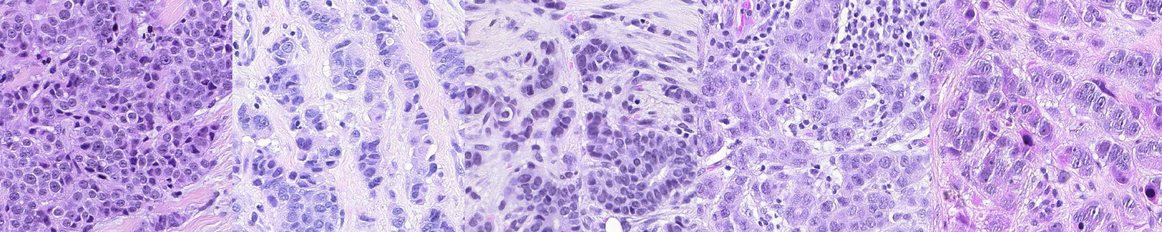

Top-k LUSC-like test samples to LUSC prototype


ValueError: Could not save to JPEG for display

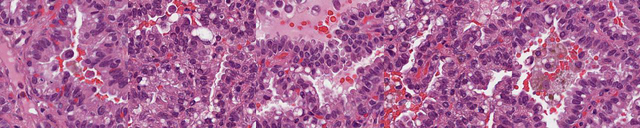

In [14]:
dist, topk_inds = proto_clf._get_topk_queries_inds(test_feats, topk=5)
print('label2idx correspondenes', train_dataset.class_to_idx)
test_imgs_df = pd.DataFrame(test_dataset.imgs, columns=['path', 'label'])

print('Top-k LUAD-like test samples to LUAD prototype')
luad_topk_inds = topk_inds[0]
luad_topk_imgs = concat_images([Image.open(img_fpath) for img_fpath in test_imgs_df['path'][luad_topk_inds]], scale=0.5)
display(luad_topk_imgs)

print('Top-k LUSC-like test samples to LUSC prototype')
lusc_topk_inds = topk_inds[1]
lusc_topk_imgs = concat_images([Image.open(img_fpath) for img_fpath in test_imgs_df['path'][lusc_topk_inds]], scale=0.5)
display(lusc_topk_imgs)

Using `proto_clf._get_topk_prototypes_inds`, we can instead use the prototypes as the query set, and get the top-k queries to each test sample. With k set to # of prototypes / labels, we are essentially doing ROI classification (assigning label of the nearest prototype to the test sample).

In [17]:
dist, topk_inds = proto_clf._get_topk_prototypes_inds(test_feats, topk=2)
print("The top-2 closest prototypes to each test sample, with closer prototypes first (left hand side)")
display(topk_inds)

print('Labels of the top-1 closest prototypes')
pred_test = topk_inds[:, 0]

The top-2 closest prototypes to each test sample, with closer prototypes first (left hand side)


array([[0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0]], dtype=int64)

Labels of the top-1 closest prototypes
